In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy
import numpy.linalg as la
import math

In [2]:
def getCorners(img, numCorners):
    quality_level = 0.01
    min_distance = 10

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.squeeze(np.int0(cv2.goodFeaturesToTrack(gray_img, numCorners, quality_level, min_distance)))

def embed_corners(img, corners):
    for i in corners:
        x, y = i
        cv2.circle(img ,(x,y),3,255,-1)
    return img

In [3]:
def _get_patches(img, corners):
    img = img[:, :, 0]
    height, width = img.shape
    patches = []
    for corner in corners:
        corner_y, corner_x = corner[0], corner[1]
        patch_start_y, patch_end_y = max(corner_y - 7, 0), min(corner_y + 8, height)
        patch_start_x, patch_end_x = max(corner_x - 7, 0), min(corner_x + 8, width)
        patch = img[patch_start_y:(patch_end_y + 1), patch_start_x:(patch_end_x + 1)]
        if len(patch) != 0:
            patches.append(patch)
    return patches

def _calculate_magnitude_orientation(patch, row=2, col=2):
    len_y, len_x = patch.shape
    sub_patches = []
    for row_idx in range(row):
        row_start, row_end = int(row_idx * len_y / row), int((row_idx * len_y / row) + (len_y / row))
        for col_idx in range(col):
            col_start, col_end = int(col_idx * len_y / col), int((col_idx * len_y / col) + (len_y / col))
            sub_patches.append(patch[row_start:row_end, col_start:col_end])

    sub_patch_magnitude = []
    sub_patch_orientation = []
    for sub_patch in sub_patches:
        if len(sub_patch) != 0:
            grad_x = cv2.Sobel(sub_patch, cv2.CV_64F, 1, 0)
            grad_y = cv2.Sobel(sub_patch, cv2.CV_64F, 0, 1)

            sub_patch_magnitude.append(np.sqrt(grad_x ** 2 + grad_y ** 2))
            orientations = np.rad2deg(np.arctan2(grad_y, grad_x))
            orientations[orientations < 0] = orientations[orientations < 0] + 180
            sub_patch_orientation.append(orientations)

    return sub_patch_magnitude, sub_patch_orientation

def _calculate_histogram(magnitudes, orientations):
    histogram_vector = [np.zeros(9) for _ in range(len(magnitudes))]
    for magnitude_idx, magnitude in enumerate(magnitudes):
        orientation = orientations[magnitude_idx]
        for mag_row in range(magnitude.shape[0]):
            for mag_col in range(magnitude.shape[1]):
                val_mag = magnitude[mag_row, mag_col]
                val_or = orientation[mag_row, mag_col]
                hist_idx = int(val_or / 20) % 9
                next_hist_idx = (hist_idx + 1) % 9
                hist_idx_increment = (np.abs(val_or - (next_hist_idx * 20)) / 20) * val_mag
                next_hist_idx_increment = (np.abs(val_or - (hist_idx * 20)) / 20) * val_mag
                histogram_vector[magnitude_idx][hist_idx] += hist_idx_increment
                histogram_vector[magnitude_idx][next_hist_idx] += next_hist_idx_increment
    histogram_vector = np.asarray(histogram_vector).reshape(-1)
    eps = 10**(-5)
    # normalize histogram
    histogram_vector_norm = np.sqrt(la.norm(histogram_vector) ** 2 + eps)
    histogram_vector = histogram_vector / histogram_vector_norm
    return histogram_vector

def getFeatures(img, corners):
    features = []
    # create patches 16x16 surrounding the corner pixels
    patches = _get_patches(img, corners)
    for patch in patches:
        # for each patch calculate the magnitude and orientation of 8x8 subpatches
        magnitudes, orientations = _calculate_magnitude_orientation(patch)
        # for each subpatches calculate the histogram
        hist_patch = _calculate_histogram(magnitudes, orientations)
        features.append(hist_patch)
    return np.asarray(features)

In [4]:
def getMatches(feat1, feat2):
    matches = []
    for row_feat1_idx, row_feat1 in enumerate(feat1):
        min_dist = math.inf
        min_arg = -1
        for row_feat2_idx, row_feat2 in enumerate(feat2):
            dist = la.norm(row_feat1 - row_feat2)
            if min_dist > dist:
                min_dist = dist
                min_arg = row_feat2_idx
        matches.append([row_feat1_idx, min_arg])

    return np.asarray(matches)

In [5]:
def plot_sbs(img_01, img_02, img_03, ext=''):
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_01)
    plt.axis('off')
    plt.title('orig{}'.format(ext))
    plt.subplot(132)
    plt.imshow(img_02)
    plt.axis('off')
    plt.title('trf1{}'.format(ext))
    plt.subplot(133)
    plt.imshow(img_03)
    plt.axis('off')
    plt.title('trf2{}'.format(ext))
    plt.show()

def plot_matches(img_01, img_02, img_01_corners, img_02_corners, matches):
    width_blank = 30
    concat_img_height = max(img_01.shape[0], img_02.shape[0])
    concat_img_width = img_01.shape[1] + img_02.shape[1] + width_blank
    concat_img = np.zeros((concat_img_height, concat_img_width, img_01.shape[2])).astype(int)
    concat_img[0:img_01.shape[0], 0:img_01.shape[1], :] = img_01
    concat_img[0:img_02.shape[0], img_01.shape[1] + width_blank:concat_img_width, :] = img_02
    y_corner_coordinates_img_01 = img_01_corners[:, 1]
    x_corner_coordinates_img_01 = img_01_corners[:, 0]
    y_corner_coordinates_img_02 = img_02_corners[:, 1]
    x_corner_coordinates_img_02 = img_02_corners[:, 0] + img_01.shape[1] + width_blank
    plt.figure()
    plt.imshow(concat_img)
    plt.scatter(x_corner_coordinates_img_01, y_corner_coordinates_img_01, s=10)
    plt.scatter(x_corner_coordinates_img_02, y_corner_coordinates_img_02, s=10)
    for match in matches:
        img_01_corner_idx, img_02_corner_idx = match[0], match[1]
        x_axis = [img_01_corners[img_01_corner_idx][0], img_02_corners[img_02_corner_idx][0] + img_01.shape[1] + width_blank]
        y_axis = [img_01_corners[img_01_corner_idx][1], img_02_corners[img_02_corner_idx][1]]
        plt.plot(x_axis, y_axis, 'g')
    plt.show()

# The starter code for Problem 5 is shown below. You have to implement the portions in ## comment

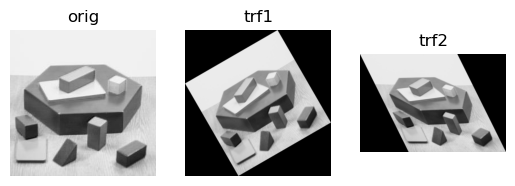

In [6]:
orig_I = cv2.imread('blocks.png')
trf1_I = cv2.imread('blocks_tform1.png')
trf2_I = cv2.imread('blocks_tform2.png')

plot_sbs(orig_I, trf1_I, trf2_I)

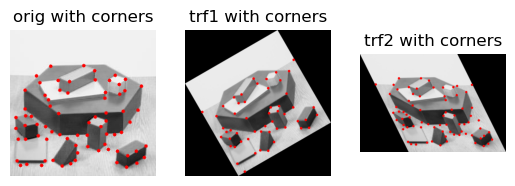

In [7]:
numCorners=75
corners_orig_I = getCorners(orig_I,numCorners)
corners_trf1_I = getCorners(trf1_I,numCorners)
corners_trf2_I = getCorners(trf2_I,numCorners)

orig_I_corners_embedded = embed_corners(copy.deepcopy(orig_I), corners_orig_I)
trf1_I_corners_embedded = embed_corners(copy.deepcopy(trf1_I), corners_trf1_I)
trf2_I_corners_embedded = embed_corners(copy.deepcopy(trf2_I), corners_trf2_I)

plot_sbs(orig_I_corners_embedded, trf1_I_corners_embedded, trf2_I_corners_embedded, ext=' with corners')

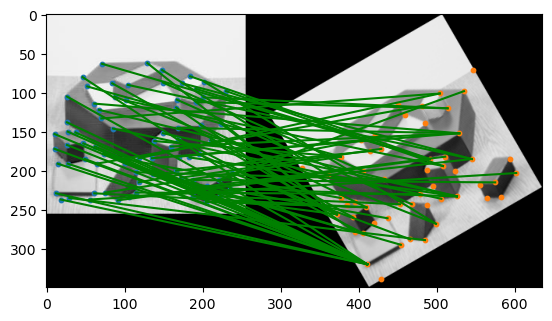

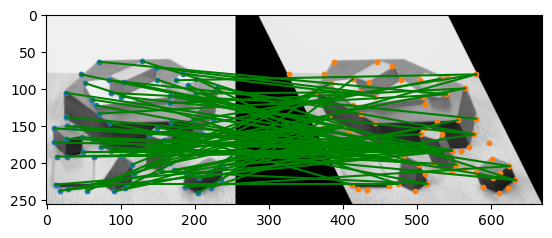

In [8]:
# compute HoG features of all images using the corner coordinate information
feat_orig_I = getFeatures(orig_I,corners_orig_I)
feat_trf1_I = getFeatures(trf1_I,corners_trf1_I)
feat_trf2_I = getFeatures(trf2_I,corners_trf2_I)

## plot the coordinates corners of all the images

# match features of original and each transformed image
matches1 = getMatches(feat_orig_I,feat_trf1_I)
matches2 = getMatches(feat_orig_I,feat_trf2_I)

plot_matches(orig_I, trf1_I, corners_orig_I, corners_trf1_I, matches1)
plot_matches(orig_I, trf2_I, corners_orig_I, corners_trf2_I, matches2)